### Imports

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [8]:
# Load the dataset
df = pd.read_csv(os.path.join(os.getcwd() , 'datasets' , 'Mall_customers.csv'))
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# reformat the column names for easier access
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [15]:
df.head()

,customerid,gender,age,annual_income_(k$),spending_score_(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df.shape

(200, 5)

In [17]:
# Display the data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   customerid              200 non-null    int64 
 1   gender                  200 non-null    object
 2   age                     200 non-null    int64 
 3   annual_income_(k$)      200 non-null    int64 
 4   spending_score_(1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income_(k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score_(1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [19]:
#check duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# remove the 'customerid' column as it is not needed for clustering
df = df.drop(columns=['customerid'])

In [29]:
# remove the 'gender' column as it is categorical and not needed for clustering
df = df.drop(columns=['gender'])

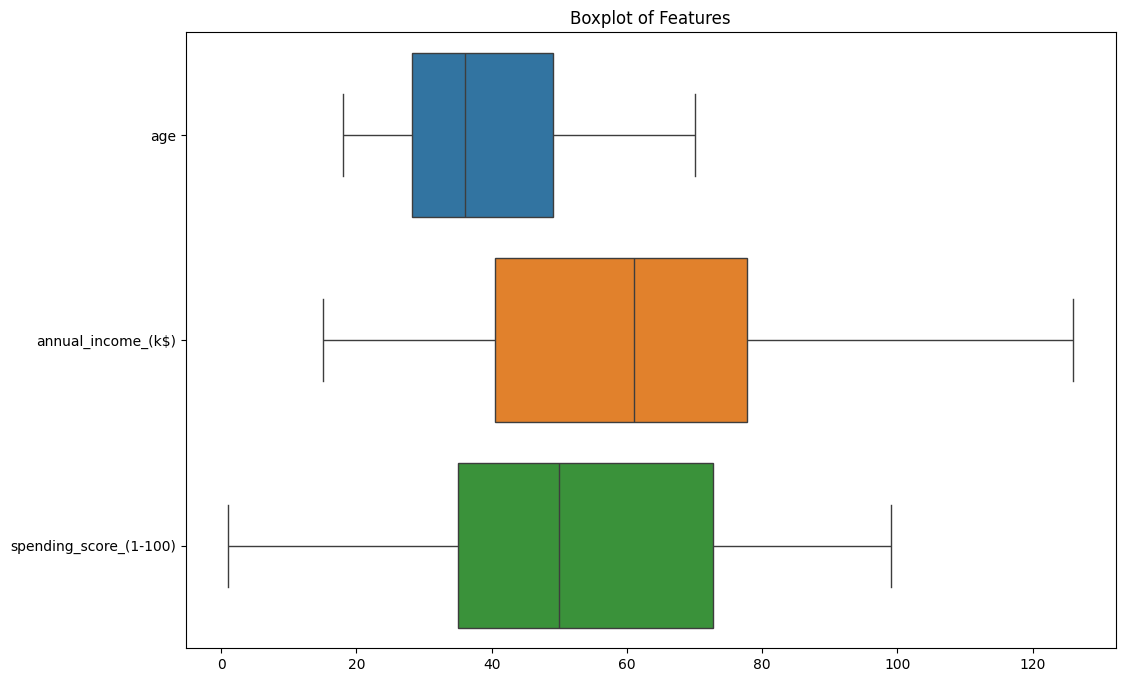

In [30]:
# check for outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot of Features')
plt.show()


In [31]:
# remove outliers
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
df.shape


(198, 3)

In [32]:
df.head()

,age,annual_income_(k$),spending_score_(1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [33]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [36]:
df_scaled

array([[-1.42541358, -1.77917141, -0.43598941],
       [-1.2823665 , -1.77917141,  1.19941337],
       [-1.35389004, -1.73944701, -1.72094874],
       [-1.13931942, -1.73944701,  1.04366072],
       [-0.5671311 , -1.69972262, -0.39705125],
       [-1.21084296, -1.69972262,  1.00472256],
       [-0.28103694, -1.65999822, -1.72094874],
       [-1.13931942, -1.65999822,  1.70560947],
       [ 1.79314572, -1.62027383, -1.83776323],
       [-0.63865464, -1.62027383,  0.84896992],
       [ 2.00771635, -1.62027383, -1.40944345],
       [-0.28103694, -1.62027383,  1.90030028],
       [ 1.36400448, -1.58054943, -1.37050529],
       [-1.06779588, -1.58054943,  1.04366072],
       [-0.13798986, -1.58054943, -1.44838161],
       [-1.21084296, -1.58054943,  1.12153705],
       [-0.28103694, -1.54082504, -0.59174206],
       [-1.35389004, -1.54082504,  0.61534095],
       [ 0.93486324, -1.46137625, -0.82537103],
       [-0.28103694, -1.46137625,  1.86136212],
       [-0.28103694, -1.42165185, -0.591

In [37]:
# try different numbers of components for GMM
from sklearn.mixture import GaussianMixture
bic_scores = []
n_componets_range = range(1, 7)
for n in n_componets_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))

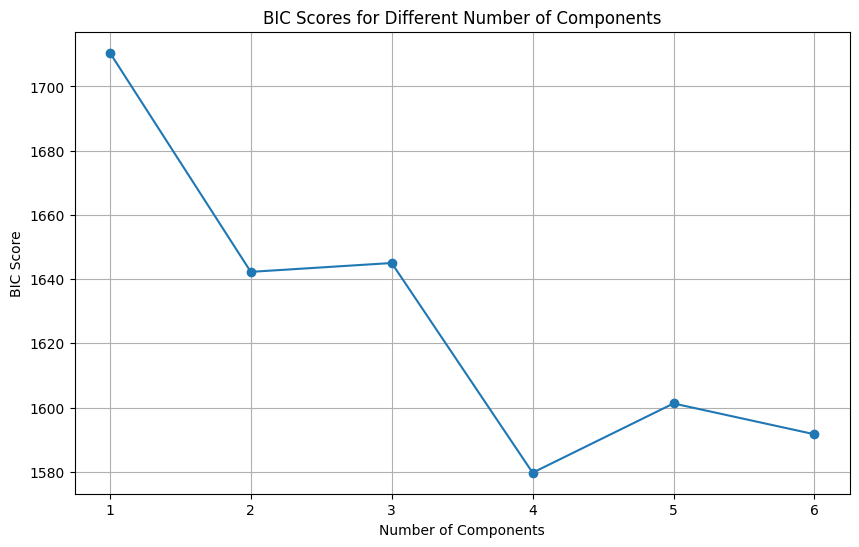

In [38]:
# Plot the BIC scores for different numbers of components
plt.figure(figsize=(10, 6))
plt.plot(n_componets_range, bic_scores, marker='o')
plt.title('BIC Scores for Different Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.xticks(n_componets_range)
plt.grid()
plt.show()


In [43]:
# Fit the GMM with the optimal number of components
optimal_n_components = 4
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(df_scaled)

GaussianMixture(n_components=4, random_state=42)

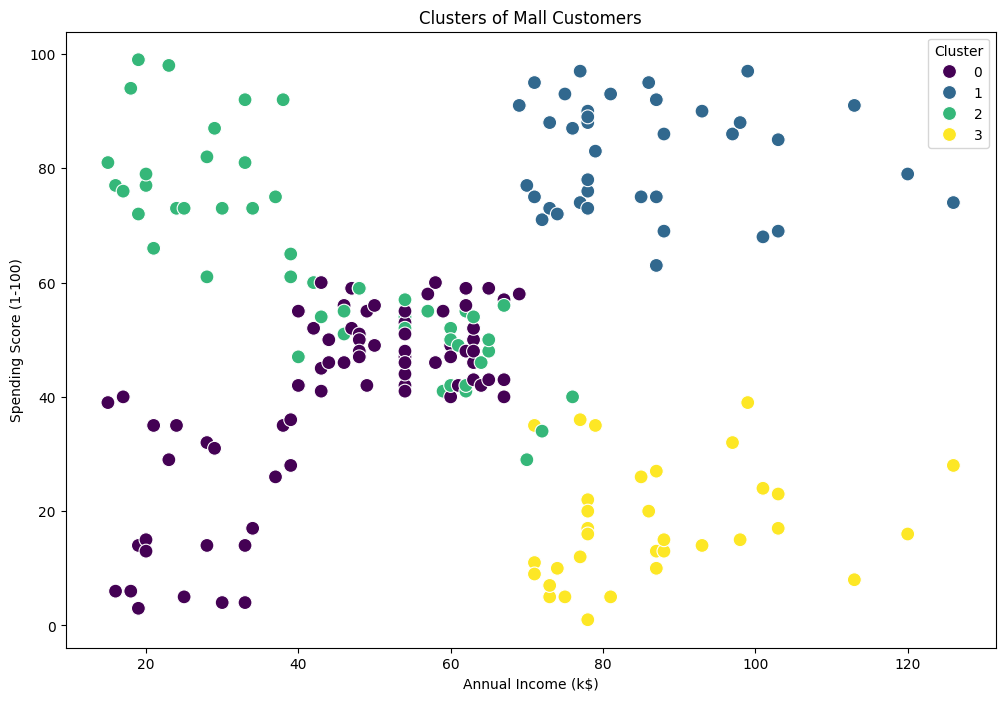

In [44]:
# Predict the cluster labels
df['cluster'] = gmm.predict(df_scaled)
# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='annual_income_(k$)', y='spending_score_(1-100)', hue='cluster', palette='viridis', s=100)
plt.title('Clusters of Mall Customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

In [45]:
# evaluation
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df_scaled, df['cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')
log_likelihood = gmm.score(df_scaled)
print(f'Log Likelihood: {log_likelihood:.2f}')

Silhouette Score: 0.38
Log Likelihood: -3.47


In [46]:
# append labels to the original dataframe
df['cluster'] = df['cluster'].astype(str)

In [47]:
df

,age,annual_income_(k$),spending_score_(1-100),cluster
0,19,15,39,0
1,21,15,81,2
2,20,16,6,0
3,23,16,77,2
4,31,17,40,0
...,...,...,...,...
193,38,113,91,1
194,47,120,16,3
195,35,120,79,1
196,45,126,28,3
